# Exercise 4a: Fully connected autoencoder on MNIST dataset

Your challenge, if you should accept it, is to tune a fully connected autoencoder on the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). 

## Fully Connected Autoencoder

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" alt="nn" style="width: 400px;"/>

## MNIST Dataset Review

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import gzip, binascii, struct
from IPython.display import Image
%matplotlib inline

### Import, scale, transform data

In the next few cells, we will be downloading the mnist data, scaling the images so that pixel values are between [0, 1], and transforming images to numpy arrays. Note that functions for extracting and transforming labels are present, but not called - we will not use labels in this activity. These initial sections are repeated from previous exercises and so will be done without further comment.  

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
train_images = mnist.train.images
test_images = mnist.test.images
print("Shape of the training set: ", train_images.shape)
print("Shape of the test set: ", test_images.shape)

Shape of the training set:  (55000, 784)
Shape of the test set:  (10000, 784)


Note the data shape. The images are already flattened out, so we are good to go for making a fully connected autoencoder. We'd need to do a little more work for a convolutional autoencoder. Training batches will have shape (n_samples, 784)

### Segmenting data into training, test, and validation

The final step in preparing our data is to split it into three sets: training, test, and validation. This isn't the format of the original data set, so we'll take a small slice of the training data and treat that as our validation set.

In [6]:
VALIDATION_SIZE = 5000

# first, let's split the flattened data - we will skip doing the labels, since we are doing an autoencoder
validation_images = train_images[:VALIDATION_SIZE, :]
train_images = train_images[VALIDATION_SIZE:, :]

train_size = train_images.shape[0]

print('Validation shape', validation_images.shape)
print('Train size', train_size)

Validation shape (5000, 784)
Train size 50000


## Defining the model

Now that we've downloaded and prepared our data, we're ready to define our model.

#### Define Hyperparameters

First, let's define some hyperparameters. You may want to change these later to try for better results!

In [8]:
# this gives us the size of input and output data - you shouldn't change this
FEATURES = train_images.shape[1]

# Tunable hyperparameters - tweak away!
BATCH_SIZE = 60

# The random seed that defines initialization.
SEED = 42

# Optimizer hyperparameters, can be tuned
LEARNING_RATE = 0.002
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-08

# Define the optimizer operation - can also pick a different optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE,
                                  beta1=BETA1,
                                  beta2=BETA2,
                                  epsilon=EPSILON,
                                  )

#### Define placeholder tensor to feed data

Normally, we would also define a placeholder tensor for y. Since we are doing an autoencoder, we are training X vs. X, so we only need an X placeholder!

In [9]:
X = tf.placeholder(tf.float32, shape=(None, FEATURES))

#### Defining weights for the fully connected autoencoder

Note that this autoencoder is using fully connected layers, so the weights will be two dimensional matrices. 

The tunable hyperparameters are not the only thing that affects your model....your architecture and initialization of weights also. Try changing weight initializations, number of neurons, or adding more layers. 

In [10]:
# encoder portion where dimensionality decreases
enc1_weights = tf.Variable(
  tf.truncated_normal([FEATURES, 500],  
                      stddev=0.1,
                      seed=SEED))
enc1_biases = tf.Variable(tf.zeros([500]))

enc2_weights = tf.Variable(
  tf.truncated_normal([500, 100], 
                      stddev=0.1,
                      seed=SEED))
enc2_biases = tf.Variable(tf.constant(0.1, shape=[100]))

# decoder portion where dimensionality increases
dec1_weights = tf.Variable(  
  tf.truncated_normal([100, 500],
                      stddev=0.1,
                      seed=SEED))
dec1_biases = tf.Variable(tf.constant(0.1, shape=[500]))

dec2_weights = tf.Variable(
  tf.truncated_normal([500, FEATURES],
                      stddev=0.1,
                      seed=SEED))
dec2_biases = tf.Variable(tf.constant(0.1, shape=[FEATURES]))



In [11]:
def fc_model(data, train=False):
    """The fully connected autoencoder model definition."""
    
    # First encoding layer
    enc1 = tf.nn.relu(tf.matmul(data, enc1_weights) + enc1_biases)

    # Second encoding layer
    enc2 = tf.nn.relu(tf.matmul(enc1, enc2_weights) + enc2_biases)

    # First decoding layer  
    dec1 = tf.nn.relu(tf.matmul(enc2, dec1_weights) + dec1_biases)

    # skipping dropout for now - try this for better results!
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    # if train:
    #     dec1 = tf.nn.dropout(dec1, 0.5, seed=SEED)
    
    # return the last layer (second decoder) with no activation
    return tf.matmul(dec1, dec2_weights) + dec2_biases

Define loss and training operations. We are comparing the reconstructed output to the input.


In [12]:
autoencoder = fc_model(X, True)
loss_op = tf.reduce_mean((X - autoencoder)**2) # pixel-wise MSE

In [13]:
train_op = optimizer.minimize(loss_op)

In [14]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

This code will plot your test images vs. the reconstructed images from the autoencoder. This will help you visualize how well your autoencoder is doing! We will call this function in the train block

In [15]:
def plot_reconstruction(X_orig, X_decoded, n = 10, plotname = None):
    '''
    inputs: X_orig (2D np array of shape (nrows, 784))
            X_recon (2D np array of shape (nrows, 784))
            n (int, number of images to plot)
            plotname (str, path to save file)
    '''
    fig = plt.figure(figsize=(n*2, 4))
    for i in range(n):
        # display original
        ax = fig.add_subplot(2, n, i + 1)
        plt.imshow(X_orig[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = fig.add_subplot(2, n, i + 1 + n)
        plt.imshow(X_decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.suptitle('Reconstructed inputs')

    if plotname:
        plt.savefig(plotname)
    else:
        plt.show()       

Finally, a function to train your autoencoder... 

In [22]:
def train(num_epochs): 
    """Function that trains model """
    train_size = train_images.shape[0]
    steps = num_epochs * train_size // BATCH_SIZE
    steps_per_epoch = train_size // BATCH_SIZE
          
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)    
          
        for step in range(steps):
            # Compute the offset of the current minibatch in the data.
            # Note that we could use better randomization across epochs.
            offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
            batch_data = train_images[offset:(offset + BATCH_SIZE), :]
          
            # Run the training operation to update the weights, use a feed_dict to use the batches you created above
            sess.run(train_op, feed_dict={X: batch_data})
        
            # display output if desired
            if step % steps_per_epoch == 0:
                loss = sess.run(loss_op, feed_dict={X: batch_data})
                print("Epoch {}, Minibatch MSE= {:.3f}".format(str(step//steps_per_epoch), loss))
            
                val_loss = sess.run(loss_op, feed_dict = {X: validation_images})
                print("Validation MSE : {}".format(val_loss))

        print("Optimization Finished!")
          
        # Run the accuracy operations for the CIFAR10 test images
        test_decoded, test_loss = sess.run([autoencoder, loss_op], feed_dict={X: test_images})
        print("Test MSE : {}".format(test_loss))
        plot_reconstruction(test_images, test_decoded) 

Finally, train your autoencoder. Is this enough epochs? 
(Hint: is your validation error decreasing or stagnating/rising?)

Advanced practitioners might want to make a more sophisticated stopping criteria than just training a constant number of epochs....once they have improved their results.

Epoch 0, Minibatch MSE= 0.281
Validation MSE : 0.30604222416877747
Epoch 1, Minibatch MSE= 0.059
Validation MSE : 0.060390450060367584
Epoch 2, Minibatch MSE= 0.037
Validation MSE : 0.04216735437512398
Epoch 3, Minibatch MSE= 0.024
Validation MSE : 0.02807694301009178
Epoch 4, Minibatch MSE= 0.024
Validation MSE : 0.022330014035105705
Epoch 5, Minibatch MSE= 0.024
Validation MSE : 0.020746054127812386
Optimization Finished!
Test MSE : 0.020404230803251266


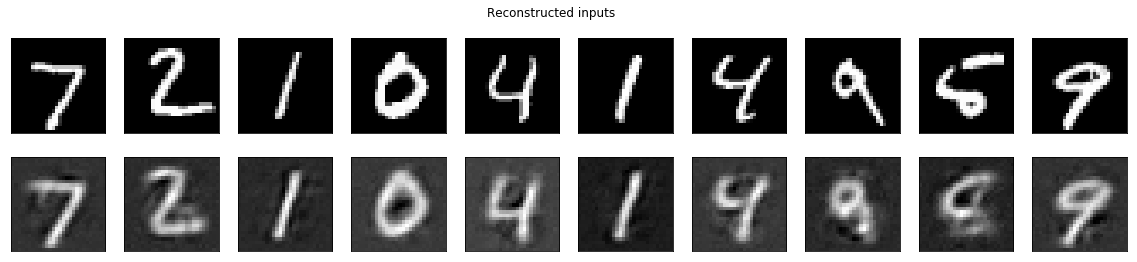

In [23]:
train(5)